# Get data from yahoo, after the ichart interface is gone.


**Author: Jev Kuznetsov**

On 18 May 2017 the `ichart` data api of yahoo finance went down, without any notice. And it does not seem like it is coming back. This has left many (including me) without a descent free end-of-day data source. 

It appears that Yahoo now tries to block automatic requests by requiring a combination of a *cookie* and a *crumb* token. 

There are ways around it, pointers to how to do it can be found on [stackoverflow](http://stackoverflow.com/questions/44030983/yahoo-finance-url-not-working)

The script below executes the steps needed to get the data and at the same time demonstrates the use of a couple very handy python libraries


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import requests # interaction with the web
import os  #  file system operations
import yaml # human-friendly data format
import re  # regular expressions
import pandas as pd # pandas... the best time series library out there
import datetime as dt # date and time functions
import io 

## Get cookie and token

The cookie and token can be used for about a year, so it's better to download them once and save to file


In [3]:
# search with regular expressions

# "CrumbStore":\{"crumb":"(?<crumb>[^"]+)"\}

url = 'https://uk.finance.yahoo.com/quote/AAPL/history' # url for a ticker symbol, with a download link
r = requests.get(url)  # download page

txt = r.text # extract html


cookie = r.cookies['B'] # the cooke we're looking for is named 'B'
print('Cookie: ', cookie)

# Now we need to extract the token from html. 
# the string we need looks like this: "CrumbStore":{"crumb":"lQHxbbYOBCq"}
# regular expressions will do the trick!

pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')

for line in txt.splitlines():
    m = pattern.match(line)
    if m is not None:
        crumb = m.groupdict()['crumb']
        
        
print('Crumb=',crumb)

Cookie:  ctdg6u1ci1a3o&b=3&s=u5
Crumb= YoBpll1PYIi


In [4]:
# create data directory in the user folder
dataDir = os.path.expanduser('~')+'/twpData'

if not os.path.exists(dataDir):
    os.mkdir(dataDir)


# save data to YAML file
data = {'cookie':cookie,'crumb':crumb}

dataFile = os.path.join(dataDir,'yahoo_cookie.yml')

with open(dataFile,'w') as fid:
    yaml.dump(data,fid)

## Define start and end times

start and end times of the requested data are in seconds since epoch (1 Jan 1970)
these are easey to get with `timestamp()` 

`https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=1463754366&period2=1495290366&interval=1d&events=history&crumb=DB/mJy8XKWr`

In [5]:

# start with tuples ...
sDate = (2009,1,1)
eDate = (2017,5,20)
 
dt.datetime(*sDate).timestamp() # convert to seconds since epoch

1230764400.0

## Get data

now it's time to get data from yahoo

In [6]:

# prepare input data as a tuple
data = (int(dt.datetime(*sDate).timestamp()),
        int(dt.datetime(*eDate).timestamp()), 
        crumb)


url = "https://query1.finance.yahoo.com/v7/finance/download/VXX?period1={0}&period2={1}&interval=1d&events=history&crumb={2}".format(*data)


print(url)
data = requests.get(url, cookies={'B':cookie})

https://query1.finance.yahoo.com/v7/finance/download/VXX?period1=1230764400&period2=1495231200&interval=1d&events=history&crumb=YoBpll1PYIi


In [7]:
buf = io.StringIO(data.text) # create a buffer
df = pd.read_csv(buf,index_col=0) # convert to pandas DataFrame
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-30,25628.160156,26890.240234,25536.000000,104.580002,26772.480469,800
2009-02-02,27673.599609,27673.599609,26608.640625,104.250000,26688.000000,1200
2009-02-03,26659.839844,26659.839844,25423.359375,99.370003,25438.720703,600
2009-02-04,25152.000000,25699.839844,24832.000000,99.739998,25533.439453,600
2009-02-05,26009.599609,26570.240234,25126.400391,99.129997,25377.279297,900


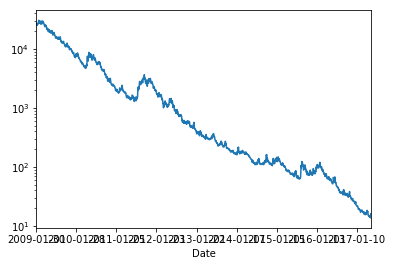

In [8]:
# plot 
df['Adj Close'].plot(logy=True)

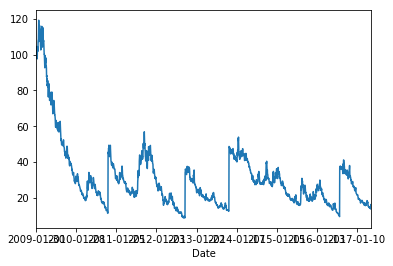

In [9]:
# the closing price is not adjustes for splits ...
df.Close.plot()